# Customer Profitability
-----------------------------------------------------------------------------

## ! Important
For this code I divided the data into several csv file. You need to have ALL the csv files to run the code.

In [24]:
import pandas as pd ; import numpy as np ; import itertools ; import matplotlib.pyplot as plt

Some important values for the code, if you change the model remember to change these variables.

In [2]:
prices = np.array([100000,150000,200000], dtype = float)
activity = ['Order', 'Warehouse', 'Assembly', 'Quality Control', 'Administration']
products = ['Subsea 1', 'Subsea 2', 'Subsea 3']
direct_cost = np.array([60976, 121065, 20964])
units_sold = [492,413,477]

## Step 1: Add orders data

In [3]:
orders = pd.read_csv('orders.csv', index_col = 'Customer')
orders.columns = products
orders.head()

,Subsea 1,Subsea 2,Subsea 3
Customer,,,
1,10,20,20
2,50,30,0
3,40,10,20
4,20,5,5
5,1,2,3


I added here a list for the customer number / id. 

In [4]:
custom = np.array(range(1,len(orders) +1)) 

We add the information about the costs.

In [5]:
cost_info = pd.read_csv('cost_info.csv')

# Be careful, sometimes the data is is accounting mode in excel, before using it we have to clean it. 
#If you don't need it please skip
# print(cost_info.head()) # We see that we have numbers in Actitvy cost and costd river units 
# cost_info.dtypes # But this show that they are considered object and not number I'll change that
#cost_info["Activity Cost"] = cost_info["Activity Cost"].replace({'\$':''}, regex = True)
#cost_info[["Activity Cost", "Cost Driver Units"]] = cost_info[["Activity Cost", "Cost Driver Units"]].replace({',':''}, regex = True)
cost_info[["Activity Cost", "Cost Driver Units"]] = cost_info[["Activity Cost", "Cost Driver Units"]].apply(pd.to_numeric)
cost_info.loc[3,'Activity'] = 'Quality Control'
cost_info.head()

,Activity,Activity Cost,Cost Driver,Cost Driver Units
0,Order,9000000.0,Order lines,5528.0
1,Warehouse,14000000.0,Pallets,1859.0
2,Assembly,47000000.0,Components,139425.0
3,Quality Control,5000000.0,Orders,1106.0
4,Administration,29000000.0,Products,3.0


We see that the Unit cost per activity is missing I'm therefore computing it.

In [6]:
cost_info['Unit Cost'] = np.round(cost_info['Activity Cost'] / cost_info['Cost Driver Units'],2)
cost_info #Average unit cost per unit

,Activity,Activity Cost,Cost Driver,Cost Driver Units,Unit Cost
0,Order,9000000.0,Order lines,5528.0,1628.08
1,Warehouse,14000000.0,Pallets,1859.0,7530.93
2,Assembly,47000000.0,Components,139425.0,337.10
3,Quality Control,5000000.0,Orders,1106.0,4520.80
4,Administration,29000000.0,Products,3.0,9666666.67


## Step 2: Compute Revenues

In [7]:
n = [] #Initiate a list to store the values for the loop
for i in range(len(prices)):
    n.append(orders.iloc[:,i] * prices[i]) #Multiply the quantity ordered by the prices

# I set my revenues into a dataset because it makes it easier to select specific values    
revenues = pd.DataFrame(np.transpose(n), columns = products)
revenues['Revenue per customer'] = revenues.sum(axis=1)
revenues.set_index(custom, inplace = True)
revenues.head()

,Subsea 1,Subsea 2,Subsea 3,Revenue per customer
1,1000000.0,3000000.0,4000000.0,8000000.0
2,5000000.0,4500000.0,0.0,9500000.0
3,4000000.0,1500000.0,4000000.0,9500000.0
4,2000000.0,750000.0,1000000.0,3750000.0
5,100000.0,300000.0,600000.0,1000000.0


## Step 3 : Compute Direct cost

Here the logic is quite similar to what we had for revenues.

In [8]:
n = []
for i in range(len(direct_cost)):
    n.append(orders.iloc[:,i] * direct_cost[i])

directcost = pd.DataFrame(np.transpose(n), columns = products)
directcost['Direct cost per customer'] = directcost.sum(axis=1)
directcost.set_index(custom, inplace = True)
directcost.head()

,Subsea 1,Subsea 2,Subsea 3,Direct cost per customer
1,609760,2421300,419280,3450340
2,3048800,3631950,0,6680750
3,2439040,1210650,419280,4068970
4,1219520,605325,104820,1929665
5,60976,242130,62892,365998


## Step 4 : Compute Indirect cost

This is the challening part, I had to proceed in multiple steps :
- Identify the cost drivers used per product line
- Using the number of cost drivers compute the cost of activities per product line
- Add the csv file with the details of what drivers were actually used per customers
- Compute the indirect costs for the activities where we have the detailed data
- Compute the indirect costs for the activities where we DON'T have the detailed data

In [9]:
cost_driver = pd.read_csv('costdriver.csv')
cost_driver.head(5)

,Cost Driver,Subsea1,Subsea2,Subsea3
0,Order,1120,1789,2619
1,Warehouse,300,744,815
2,Assembly,28978,40988,69459
3,QC,270,240,596
4,Administration,1,1,1


In [10]:
a = [] # List for the loop
for row, col in itertools.product(range(len(activity)), range(1,len(products)+1 )) : #+1 because at 0 we have string and not numbers in cost_driver
    # Intertools product will loop through all activities and for each activity will loop through product
    a.append((cost_driver.iloc[row, col] * cost_info.loc[row,'Unit Cost'] / units_sold[col-1]))
#The loop above returns an ugly nested list, I transformed it into a dataframe for each activity and each product
cost_per_line = pd.DataFrame([a[n:n+len(products)] for n in range(0, len(a), len(products))], columns= products)
cost_per_line['Activity'] = activity
column_to_move = cost_per_line.pop('Activity') #Just move the activity column at the front
cost_per_line.insert(0, 'Activity', column_to_move)

cost_per_line

,Activity,Subsea 1,Subsea 2,Subsea 3
0,Order,3706.198374,7052.385278,8939.080755
1,Warehouse,4592.030488,13566.614818,12867.312264
2,Assembly,19854.641870,33455.338499,49087.272327
3,Quality Control,2480.926829,2627.099274,5648.630608
4,Administration,19647.696484,23405.972567,20265.548574


In [11]:
driver_used = pd.read_csv('inderect_cost.csv', index_col = 'Customer') #Details of drivers used
driver_used.head(5)

,Order Subsea 1,Order Subsea 2,Order Subsea 3,Warehouse Subsea 1,Warehouse Subsea 2,Warehouse Subsea 3,Assembly Subsea 1,Assembly Subsea 2,Assembly Subsea 3,Quality Control Subsea 1,Quality Control Subsea 2,Quality Control Subsea 3,Administration Subsea 1,Administration Subsea 2,Administration Subsea 3
Customer,,,,,,,,,,,,,,,
1,54,225,73,NaN,NaN,NaN,NaN,NaN,NaN,17,5,4,NaN,NaN,NaN
2,65,36,0,NaN,NaN,NaN,NaN,NaN,NaN,12,7,0,NaN,NaN,NaN
3,36,59,43,NaN,NaN,NaN,NaN,NaN,NaN,2,9,23,NaN,NaN,NaN
4,4,66,52,NaN,NaN,NaN,NaN,NaN,NaN,18,5,34,NaN,NaN,NaN
5,69,66,102,NaN,NaN,NaN,NaN,NaN,NaN,3,2,22,NaN,NaN,NaN


In [12]:
ll = [] # Random list
for i, y in itertools.product(activity, products) :
    a = driver_used.loc[:,driver_used.columns.str.contains(i) & driver_used.columns.str.contains(y)].values.tolist()
    # For a I select the cost for the corresponding activity and the corresponding product
    b = cost_info.loc[cost_info['Activity'] == i, 'Unit Cost'].values
    # Just select the unit cost for the specified activity
    c = (a * b).tolist() #Extremely ugly list
    ll.append(c) # I append it into another list to have it more clean
l1 = np.array(ll).transpose().tolist() #I had to transpose the list because bad shape 
df_copy = pd.DataFrame() # Guess what a new dataframe to store my values
df_copy = df_copy.append(ll)
df_copy = df_copy.T # I had to transpose once again
df_copy.columns = driver_used.columns
df_copy = df_copy.applymap(lambda x: x[0] if isinstance(x, list) else x) #Just remove the brackets

indirectdf = pd.DataFrame() #The big database for the dataframe
for i in activity:
    cop = df_copy.loc[:,df_copy.columns.str.contains(i)].copy()
    indirectdf[i] = cop.sum(axis=1)
indirectdf
#We have a lot of zeros because NaN values = 0

,Order,Warehouse,Assembly,Quality Control,Administration
0,573084.16,0.0,0.0,117540.8,0.0
1,164436.08,0.0,0.0,85895.2,0.0
2,224675.04,0.0,0.0,153707.2,0.0
3,198625.76,0.0,0.0,257685.6,0.0
4,385854.96,0.0,0.0,122061.6,0.0
5,540522.56,0.0,0.0,433996.8,0.0
6,356549.52,0.0,0.0,180832.0,0.0
7,490052.08,0.0,0.0,266727.2,0.0
8,703330.56,0.0,0.0,411392.8,0.0
9,421672.72,0.0,0.0,275768.8,0.0


In [13]:
null_cols = df_copy.columns[df_copy.isnull().all()] 
# Gives the list of missing columns with full names ie Activity + Product
nulldf = df_copy[null_cols].copy() # Dataframe of the NaN columns
missing_act = []
for i in activity:
    if nulldf.columns.str.contains(i).any() :
        missing_act.append(i)
    else:
        None
#If Activity is in Activity + Product Return Activity name
missing_act

['Warehouse', 'Assembly', 'Administration']

In [14]:
l3 = []
for i, y in itertools.product(missing_act,products) :
    a = orders.iloc[:,orders.columns.str.contains(y)] #Select the number of orders per customers
    b = cost_per_line.loc[cost_per_line['Activity'] == i, cost_per_line.columns.str.contains(y)].values
    # Return cost per activity and per line
    c = (a * b).values.tolist() #Ugly list again
    l3.append(c)
l1 = np.array(l3).transpose().tolist()
df_copy2 = pd.DataFrame()
df_copy2 = df_copy2.append(l3)
df_copy2 = df_copy2.T
df_copy2.columns = null_cols.tolist()
df_copy2 = df_copy2.applymap(lambda x: x[0] if isinstance(x, list) else x)
df_copy2


for i in missing_act:
    cop = df_copy2.loc[:,df_copy2.columns.str.contains(i)].copy() # Select cols of the dataframe for the missing values
    indirectdf[i] = cop.sum(axis=1) # In indirect cost sum the indirect cost per customer for each product line
indirectdf['Total Indirect costs'] = indirectdf.sum(axis=1)
indirectdf.set_index(custom, inplace = True)
indirectdf

,Order,Warehouse,Assembly,Quality Control,Administration,Total Indirect costs
1,573084.16,5.745988e+05,1.849399e+06,117540.8,1.069907e+06,4.184530e+06
2,164436.08,6.366000e+05,1.996392e+06,85895.2,1.684564e+06,4.567887e+06
3,224675.04,5.766936e+05,2.110485e+06,153707.2,1.425279e+06,4.490839e+06
4,198625.76,2.240102e+05,8.098059e+05,257685.6,6.113115e+05,2.101439e+06
5,385854.96,7.032720e+04,2.340271e+05,122061.6,1.272563e+05,9.395272e+05
6,540522.56,3.921718e+05,1.121535e+06,433996.8,8.115004e+05,3.299727e+06
7,356549.52,6.013126e+05,2.262403e+06,180832.0,1.077317e+06,4.478414e+06
8,490052.08,4.265071e+05,1.456546e+06,266727.2,9.569254e+05,3.596758e+06
9,703330.56,1.094184e+06,3.613136e+06,411392.8,2.216790e+06,8.038834e+06
10,421672.72,1.196236e+06,3.933929e+06,275768.8,2.410506e+06,8.238113e+06


## Step 5: Compute Profit
(Final step, yeah :) )

In [15]:
profit = pd.DataFrame([revenues['Revenue per customer'], directcost['Direct cost per customer'], indirectdf['Total Indirect costs']]).T
# Create a new dataframe for the profit and transpose it to have it in the rigjt order
profit['Profit Per Customer'] = np.round(profit['Revenue per customer'] - profit['Direct cost per customer'] - profit['Total Indirect costs'],2)
profit

,Revenue per customer,Direct cost per customer,Total Indirect costs,Profit Per Customer
1,8000000.0,3450340.0,4.184530e+06,365130.17
2,9500000.0,6680750.0,4.567887e+06,-1748637.50
3,9500000.0,4068970.0,4.490839e+06,940191.08
4,3750000.0,1929665.0,2.101439e+06,-281104.03
5,1000000.0,365998.0,9.395272e+05,-305525.18
6,5100000.0,3458034.0,3.299727e+06,-1657760.56
7,9450000.0,1811515.0,4.478414e+06,3160070.69
8,6500000.0,3005808.0,3.596758e+06,-102565.87
9,15850000.0,7065163.0,8.038834e+06,746002.90
10,17250000.0,7734267.0,8.238113e+06,1277619.90


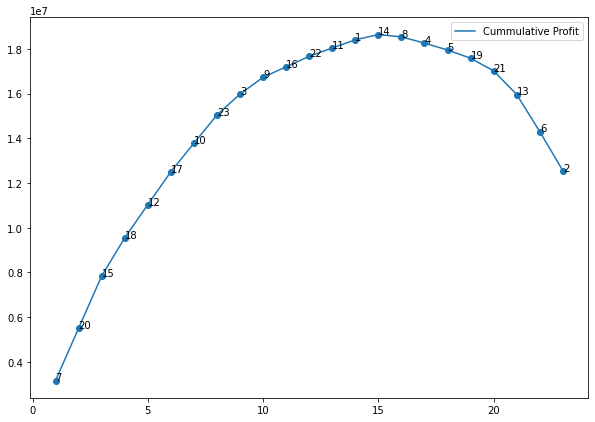

In [64]:
sorted_profit= profit.sort_values(by=['Profit Per Customer'], ascending=False)
cid = sorted_profit.index.values.tolist() ; x = profit.index.values.tolist()
y = sorted_profit['Profit Per Customer'].values.tolist()

plt.figure(figsize=(10,7))
plt.plot(x,np.cumsum(y), label = 'Cummulative Profit')
plt.scatter(x,np.cumsum(y))
for i in range(len(x)):
    plt.text(x[i], np.cumsum(y)[i], cid[i])
plt.legend() ; plt.show()